# 5.7. Kaggle House Prices – Linear Regression

In [1]:
%matplotlib inline

import sys
sys.path.append("../..")

import pandas as pd
import torch

from dataloaders import KaggleHouse
from models import LinearRegression
from utils import Trainer

In [2]:
data = KaggleHouse(batch_size=64)
data.preprocess()
data.train.shape

(1460, 331)

### k-Fold Cross-Validation

In [3]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [4]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

### Training

average validation log mse = 0.04586530700325966


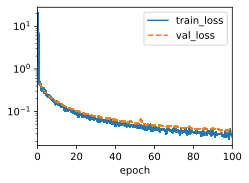

In [5]:
trainer = Trainer(max_epochs=100)
models = k_fold(trainer, data, k=5, lr=0.01)

### Submitting Predictions on Kaggle

In [6]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)